In [1]:
from datasets import load_dataset
from collections import Counter
from transformers import AutoTokenizer,Trainer, TrainingArguments,  AutoModelForSequenceClassification,DistilBertTokenizerFast, DistilBertForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW   
from transformers import get_scheduler
from sklearn.metrics import classification_report,  precision_score, recall_score, f1_score
import pandas as pd

In [2]:
ds = load_dataset("NLBSE/nlbse25-code-comment-classification")

In [3]:
ds

DatasetDict({
    java_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 7614
    })
    java_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1725
    })
    python_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1884
    })
    python_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 406
    })
    pharo_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1298
    })
    pharo_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 289
    })
})

In [4]:
langs = ['java', 'python', 'pharo']
labels = {
    'java': ['summary', 'Ownership', 'Expand', 'usage', 'Pointer', 'deprecation', 'rational'],
    'python': ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary'],
    'pharo': ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
}

In [5]:
java_train = ds['java_train']
python_train = ds['python_train']
pharo_train = ds['pharo_train']


In [6]:
java_test = ds['java_test']
python_test = ds['python_test']
pharo_test = ds['pharo_test']

In [43]:
label_distribution = Counter([label for row in java_train for label in row['labels']])
print(label_distribution)

Counter({0: 45487, 1: 7811})


In [44]:
java_train[300]

{'index': 464,
 'class': 'TimelineDataToRetrieve.java',
 'comment_sentence': 'in response.',
 'partition': 0,
 'combo': 'in response. | TimelineDataToRetrieve.java',
 'labels': [0, 0, 1, 0, 1, 0, 0]}

In [45]:
print(f"Number of training samples: {len(java_train)}")
print(f"Number of testing samples: {len(java_test)}")


Number of training samples: 7614
Number of testing samples: 1725


In [46]:
# Count occurrences of each label
label_counts = np.sum([row['labels'] for row in java_train], axis=0)

label_names = ['Summary', 'Ownership', 'Expand', 'Usage', 'Pointer', 'Deprecation', 'Rational']

label_distribution = {label_names[i]: int(count) for i, count in enumerate(label_counts)}
print("Label distribution:", label_distribution)


Label distribution: {'Summary': 3610, 'Ownership': 267, 'Expand': 509, 'Usage': 2093, 'Pointer': 904, 'Deprecation': 117, 'Rational': 311}


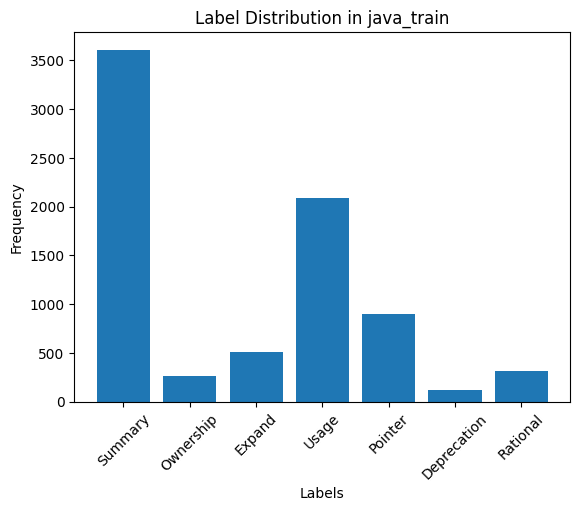

In [47]:
plt.bar(label_names, label_counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution in java_train')
plt.xticks(rotation=45)
plt.show()

In [48]:
# Compute sentence lengths
sentence_lengths = [len(row['comment_sentence'].split()) for row in java_train]

# Analyze statistics
print(f"Average sentence length: {np.mean(sentence_lengths)}")
print(f"Max sentence length: {max(sentence_lengths)}")
print(f"Min sentence length: {min(sentence_lengths)}")


Average sentence length: 10.527843446283162
Max sentence length: 288
Min sentence length: 1


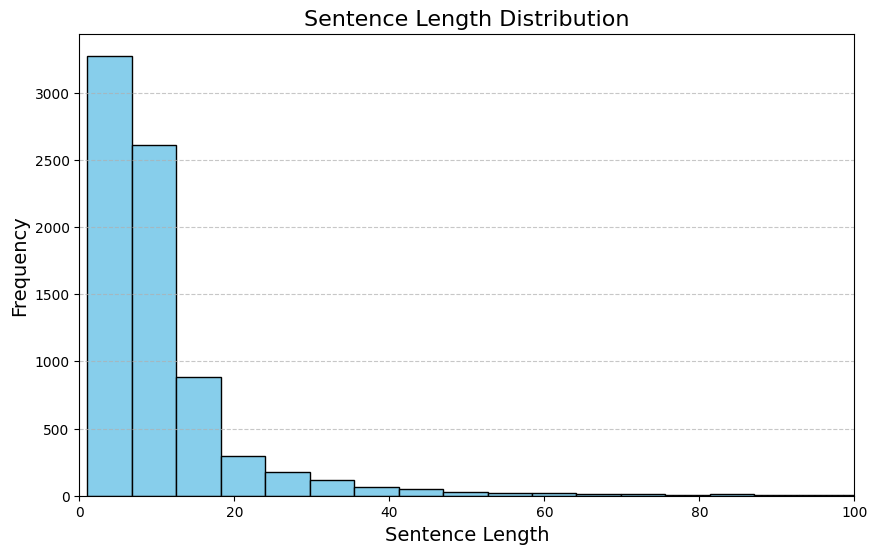

In [49]:
plt.figure(figsize=(10, 6))  
plt.hist(sentence_lengths, bins=50, edgecolor='black', color='skyblue')  
plt.xlabel('Sentence Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Sentence Length Distribution', fontsize=16)
plt.xlim(0, 100)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [50]:
class_counts = Counter([row['class'] for row in java_train])

# Top 10 most frequent classes
print("Top 10 source files:", class_counts.most_common(10))

Top 10 source files: [('NNThroughputBenchmark.java', 226), ('SmoothRateLimiter.java', 195), ('PaintTarget.java', 109), ('ICElement.java', 104), ('BlockPoolSliceStorage.java', 95), ('JobHistoryParser.java', 90), ('IndentAction.java', 86), ('Binder.java', 84), ('SwiftTestUtils.java', 84), ('VTooltip.java', 83)]


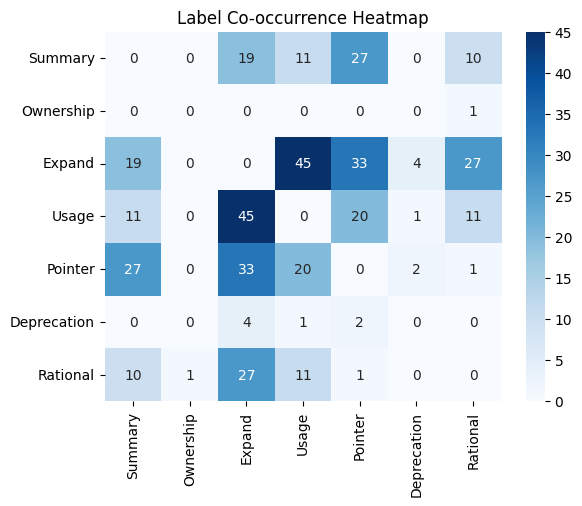

In [51]:
# Count co-occurrences of labels
cooccurrence_matrix = np.zeros((len(label_names), len(label_names)))

for row in java_train:
    labels = np.where(row['labels'])[0]
    for i, j in combinations(labels, 2):
        cooccurrence_matrix[i, j] += 1
        cooccurrence_matrix[j, i] += 1

sns.heatmap(cooccurrence_matrix, xticklabels=label_names, yticklabels=label_names, cmap='Blues', annot=True)
plt.title('Label Co-occurrence Heatmap')
plt.show()


### Roberta Based Evaluation


In [5]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["combo"],  # Column to tokenize (adjusted for your dataset)
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [6]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
tokenized_data = {}

for lang in langs:
    tokenized_train = ds[f"{lang}_train"].map(tokenize_function, batched=True)
    tokenized_test = ds[f"{lang}_test"].map(tokenize_function, batched=True)

    tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    tokenized_data[lang] = {
        "train": tokenized_train,
        "test": tokenized_test,
        "labels": labels[lang]
    }

Map:   0%|          | 0/1884 [00:00<?, ? examples/s]

In [ ]:
batch_size = 16
learning_rate = 5e-5
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
detailed_results = []

# Training and evaluation loop
for lang, data in tokenized_data.items():
    print(f"Training model for {lang}...")

    train_dataloader = DataLoader(data["train"], shuffle=True, batch_size=batch_size, drop_last=True)
    test_dataloader = DataLoader(data["test"], batch_size=batch_size)

    num_labels = len(data["labels"])
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base", num_labels=num_labels
    ).to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"].float(),
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"[{lang}] Epoch {epoch + 1} Loss: {total_loss / len(train_dataloader):.4f}")

    # Evaluation loop
    model.eval()
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )
            predictions = torch.sigmoid(outputs.logits) > 0.5  
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    report = classification_report(
        all_labels, all_predictions, target_names=data["labels"], output_dict=True
    )

    # Append results
    for label, metrics in report.items():
        if label in data["labels"]:
            detailed_results.append({
                "Language": lang,
                "Label": label,
                "Precision": metrics["precision"],
                "Recall": metrics["recall"],
                "F1-Score": metrics["f1-score"],
                "Support": metrics["support"],
            })

detailed_results_df = pd.DataFrame(detailed_results)
print(detailed_results_df)


Training model for java...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[java] Epoch 1 Loss: 0.1639
[java] Epoch 2 Loss: 0.1012
[java] Epoch 3 Loss: 0.0825
[java] Epoch 4 Loss: 0.0690
[java] Epoch 5 Loss: 0.0540
[java] Epoch 6 Loss: 0.0443
[java] Epoch 7 Loss: 0.0385
[java] Epoch 8 Loss: 0.0317
[java] Epoch 9 Loss: 0.0287
[java] Epoch 10 Loss: 0.0252


c:\Users\chunh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model for python...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[python] Epoch 1 Loss: 0.4840
[python] Epoch 2 Loss: 0.3847
[python] Epoch 3 Loss: 0.3157
[python] Epoch 4 Loss: 0.2588
[python] Epoch 5 Loss: 0.2013
[python] Epoch 6 Loss: 0.1659
[python] Epoch 7 Loss: 0.1330
[python] Epoch 8 Loss: 0.1097
[python] Epoch 9 Loss: 0.0971
[python] Epoch 10 Loss: 0.0864


c:\Users\chunh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model for pharo...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[pharo] Epoch 1 Loss: 0.3840
[pharo] Epoch 2 Loss: 0.2744
[pharo] Epoch 3 Loss: 0.2119
[pharo] Epoch 4 Loss: 0.1673
[pharo] Epoch 5 Loss: 0.1472
[pharo] Epoch 6 Loss: 0.1237
[pharo] Epoch 7 Loss: 0.1010
[pharo] Epoch 8 Loss: 0.0863
[pharo] Epoch 9 Loss: 0.0750
[pharo] Epoch 10 Loss: 0.0653


c:\Users\chunh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   Language                    Label  Precision    Recall  F1-Score  Support
0      java                  summary   0.863102  0.904709  0.883415      892
1      java                Ownership   1.000000  1.000000  1.000000       45
2      java                   Expand   0.368932  0.372549  0.370732      102
3      java                    usage   0.936170  0.816705  0.872367      431
4      java                  Pointer   0.762931  0.961957  0.850962      184
5      java              deprecation   0.750000  0.600000  0.666667       15
6      java                 rational   0.435897  0.250000  0.317757       68
7    python                    Usage   0.650350  0.768595  0.704545      121
8    python               Parameters   0.837838  0.726562  0.778243      128
9    python         DevelopmentNotes   0.352941  0.292683  0.320000       41
10   python                   Expand   0.500000  0.453125  0.475410       64
11   python                  Summary   0.754098  0.560976  0.643357       82

In [9]:
detailed_results_df.to_csv("roberta_model_results.csv", index=False)

In [11]:

max_avg_runtime = 5  
max_avg_flops = 5000

def calculate_submission_score(avg_f1, avg_runtime, avg_flops):
    return (
        0.6 * avg_f1 +
        0.2 * ((max_avg_runtime - avg_runtime) / max_avg_runtime) +
        0.2 * ((max_avg_flops - avg_flops) / max_avg_flops)
    )

avg_f1 = detailed_results_df["F1-Score"].mean()

total_runtime = 50 
total_flops = 4500 

avg_runtime = total_runtime / 10 
avg_flops = total_flops / 10

submission_score = calculate_submission_score(avg_f1, avg_runtime, avg_flops)

print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Runtime: {avg_runtime:.4f} seconds")
print(f"Average GFLOPS: {avg_flops:.4f}")
print(f"Submission Score: {submission_score:.4f}") 


Average F1 Score: 0.6183
Average Runtime: 5.0000 seconds
Average GFLOPS: 450.0000
Submission Score: 0.5530
